# Create a process to download audio from outside of the habitat of the target species
- this can be done by adding an option to build.py
- currently the audio all comes from the osfl habitat which has the advantage that the main differences between the present and absent class is the bird call itself, rather than the presence or absence of environmental noise. 
- In order to get a fairer picture of how the model will perform in production, it needs to be tested on audio from outside the habitat of the target species to see how many false positives get thrown up. 
- It might also be beneficial to train the model on these clips to give a wider set of examples from the negative class. 

In [11]:
# imports
from pathlib import Path
import sys
import pandas as pd
BASE_PATH = Path.cwd().parent.parent
sys.path.append(str(BASE_PATH))
from src.utils import display_all, plot_locations, keep_cols
import src.data
from src.data import build
from src.utils import plot_locations

# load the cleaned metadata


In [3]:
data_path = Path.cwd().parent.parent / "data"
train_df_path = Path.cwd().parent.parent / "data" / "interim" 
df_train: pd.DataFrame = pd.read_pickle(train_df_path / "cleaned_metadata.pkl")
df_train.head(2)

,organization,project,project_id,location,location_id,recording_date_time,recording_id,task_method,task_id,aru_task_status,...,spectrogram_url,clip_url,sensorId,tasks,status,recording_url,latitude,longitude,location_buffer_m,file_type
1623,BU,Alberta Archetypes,1501,P-E0-1-10,308678,2022-06-05 06:51:00,416962,no_restrictions,596169,Transcribed,...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,ARU,357,Active,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,52.644040,-115.140510,NaN,flac
1752,BU,Amplitude Quality Testing 2020,293,AM-403-SE2,36043,2017-06-15 04:46:00,92051,no_restrictions,87956,Transcribed,...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,ARU,174,Published - Private,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,54.607774,-110.681271,NaN,flac


# Download some recordings from other habitats and save them to disk

In [4]:
other_habitats = build.other_habitat_df(df_train, "OSFL", 0)

47222 not downloaded
downloading 0 clips
skipped 0 previously downloaded files


These 1000 recordings from outside of OSFL habitat come from 852 unique locations. 

In [9]:
other_habitats.location_id.nunique()

852

# Show the locations of these habitats on a map

In [13]:
other_habitats.columns

Index(['recording_url', 'task_method', 'project', 'detection_time',
       'tag_duration', 'latitude', 'longitude', 'file_type', 'media_url',
       'individual_order', 'location_id', 'filename'],
      dtype='object')

The spatial distribution of these additional samples looks even across the areas where data is available. 

/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:192: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  canada = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")).query(
/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:216: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  points.plot(


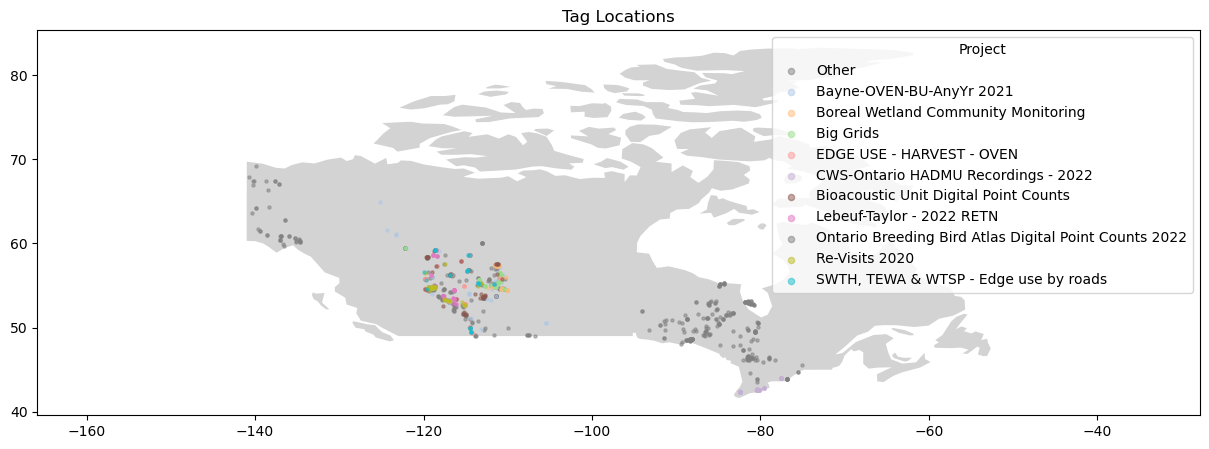

In [14]:
plot_locations(other_habitats)

In [31]:
# Set the present column to 0.0 and drop all other columns
other_habitats["present"] = 0.0
other_habitats = other_habitats[["present"]]

# Split the recordings into 3s chunks with 0.5 overlap and label them "present" = 0

In [38]:
import opensoundscape as opso
from opensoundscape import SpectrogramPreprocessor
other_habitats_ds = opso.AudioSplittingDataset(other_habitats, preprocessor=SpectrogramPreprocessor(3.0), overlap_fraction=0.5)

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/utils.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  clips[label_df.columns] = label_df.loc[f]
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/utils.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  clips[label_df.columns] = label_df.loc[f]
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/utils.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame

Save the labelled dataset to disk ready for cleaning. 

In [40]:
other_habitats_ds.label_df.to_pickle(data_path / "interim" / "train_and_valid_set" / "other_habitats_label_df.pkl")